# Single-Objective Optimisation in Ms. Pac-Man using a Genetic Algorithm

This notebook implements a simple genetic algorithm to evolve AI agents for Ms. Pac-Man. The objective is to maximise the score achieved by the agent in the game environment using the OpenAI Gymnasium framework.

In [1]:
# implemented limited discrete actions and multi-statistics to track both fitness and time

In [2]:
# import the key libraries for this phase of the project
# install Gymnasium environment and relevant package for Ms. Pac-Man, and deap for 
#  genetic algorithm

# !pip install gymnasium
# !pip install gymnasium[atari]
# !pip install deap

import gymnasium as gym
import ale_py # for Ms. Pac-Man game
from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics # to record environment and statistics
from deap import base, creator, tools, algorithms # genetic algorithm
import numpy as np
import pandas as pd
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# initialising the game with the action space

env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
env = RecordEpisodeStatistics(env)

# height = 210
# width = 160
# depth = 3
# shape = [height, width, depth]

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(9)


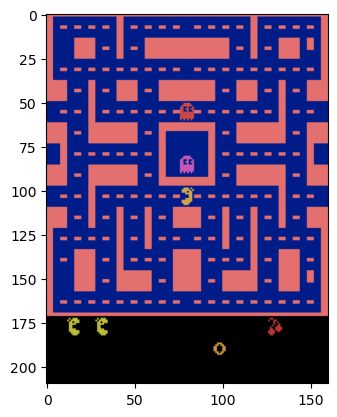

In [4]:
# shape and type of observations

observation, info = env.reset() # Reset the environment to start
plt.imshow(env.render())
plt.grid(False)

print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")

In [5]:
# Define the limited action space: UP, RIGHT, LEFT, DOWN
limited_actions = [1, 2, 3, 4]  # Indices corresponding to these actions

In [6]:
# testing environment with random actions to understand observation space and action space before proceeding with optimisation

# frame_time = 1.0 / 15  # seconds
# n_episodes = 1 # number of episodes
# scores = []

# for x_episode in range(n_episodes):
#     t = 0
#     score = 0
#     then = 0
#     terminated = False
#     env.reset()
#     while not terminated:
#         now = time.time()
#         if frame_time < now - then:
#             action = env.action_space.sample()
#             # # receiving the next observation, reward and if the episode is truncated or has terminated
#             observation, reward, terminated, truncated, info = env.step(action)
#             score += reward
#             env.render()
#             then = now
#             t = t + 1
#     scores.append(score)
#     print('Episode {} finished at t {} with score {}'.format(x_episode,t,score))
    
# print('Average score {}, max {}, min {}'.format(np.mean(scores),np.max(scores),np.min(scores)))

# env.close()

In the function below the individual (an evolved agent) is represented by a sequence of actions. The agent’s fitness is the total score (total_reward) achieved in one game episode.

In [7]:
# single-objective optimisation (maximising score)
# define a fitness function where the objective is to maximise the game score 
# this fitness function evaluates the agent based on the total_reward (score) obtained in one episode

def evaluate_agent(individual, seed=42):
    env = gym.make("ALE/MsPacman-v5")
    env = RecordEpisodeStatistics(env)
    env.reset(seed=seed)  # Set the seed for "deterministic" behaviour of environment
    observation, info = env.reset()
    
    start_time = time.time()  # Start time
    
    total_reward = 0
    terminated = False
    steps = 0
    
    # Define the limited action set (UP, RIGHT, LEFT, DOWN)
    limited_actions = [1, 2, 3, 4]
    
    while not terminated:
        # convert the individual's chromosome into actions
        action = individual[steps % len(individual)]
        
        # Map the agent's action to the limited action space
        action = limited_actions[action % len(limited_actions)]
        
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        
        # If the episode has ended then can reset to start a new episode
        if terminated or truncated:
            observation, info = env.reset()
    
    env.close()
    
    end_time = time.time()  # End time
#     time_taken = end_time - start_time  # Time taken for this agent play
    time_taken = env.time_queue
    return total_reward, time_taken  # return a tuple as DEAP expects fitness to be a tuple

In [8]:
def evaluate(individual):
    # Get the reward and time taken for this agent
    total_reward, time_taken = evaluate_agent(individual)
    
    # Return only the total reward for fitness
    return total_reward,  # Comma ensures it's a tuple as DEAP expects fitness to be a tuple

### Defining the genetic algorithm components:

Chromosome representation: Each agent (individual) is represented by a sequence of actions

Fitness function: As defined in the evaluate_agent() function above (total reward score from game)

Crossover and Mutation: To generate new individuals from the current population.

Selection mechanism: Using tournament selection

In [9]:
# Define the DEAP toolbox to register all GA components:

# Define the genetic algorithm parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximise the score
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define toolbox with genetic operators
toolbox = base.Toolbox()
toolbox.register("attr_action", lambda: random.randint(0, len(limited_actions) - 1)) # In the population generation function, map genes to limited actions
toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.attr_action, n=500) # 500 Length of action sequence; 
                                             # A list of actions where each action is
                                             # a random integer representing a movement in Ms. Pac-Man
toolbox.register("population", tools.initRepeat, list, toolbox.individual) 
                 # A collection of individuals

# Register genetic operators
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint) # Crossover: Two-point crossover to mix action sequences.
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) # Bit-flip mutation to alter some actions randomly
toolbox.register("select", tools.selTournament, tournsize=3)

In [10]:
# Fitness evaluation and visualisation

# runs the genetic algorithm for 1000 generations with 100 agents. 
# population will be evolved based on the score-maximising fitness function

def run_ga():
    # Initialise population
    population = toolbox.population(n=100)

 # Create statistics to track progress
    # Create statistics for fitness (reward)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])  # Fitness is just based on reward
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # Create custom time statistics
    def time_stat_func(ind):
        _, time_taken = evaluate_agent(ind)
        return time_taken

    time_stats = tools.Statistics(time_stat_func)
    time_stats.register("avg", np.mean)
    time_stats.register("std", np.std)
    time_stats.register("min", np.min)
    time_stats.register("max", np.max)
    
    # Multi-statistics to track both fitness and time
    mstats = tools.MultiStatistics(fitness=stats, time=time_stats)

    # Run the genetic algorithm
    final_pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, 
                                             ngen=1000, stats=mstats, verbose=True)
    
    return final_pop, logbook

## Run the GA then visualise the results

In [11]:
# Run the GA
# Visualise the results
# Plot the best fitness score over generations to observe how the optimisation 
# improves the agent’s performance

final_pop, logbook = run_ga()

# Extract generation data
gen = logbook.select("gen")
max_fitness = logbook.chapters["fitness"].select("max")
avg_time = logbook.chapters["time"].select("avg")
max_time = logbook.chapters["time"].select("max")
avg_fitness = logbook.chapters["fitness"].select("avg")

# Convert to Pandas DataFrame for better visualisation
data = {
    'Generation': gen,
    'Max Fitness': max_fitness,
    'Avg Fitness': avg_fitness,
    'Avg Time Taken (s)': avg_time,
    'Max Time Taken (s)': max_time
}

df = pd.DataFrame(data)

# Display the DataFrame
df

   	      	                    fitness                    	                                   time                                  
   	      	-----------------------------------------------	-------------------------------------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std    	avg      	gen	max     	min     	nevals	std      
0  	100   	238	0  	620	90 	100   	82.6075	0.0982066	0  	0.152295	0.066177	100   	0.0161305
1  	70    	270.4	1  	510	150	70    	58.9223	0.101834 	1  	0.15169 	0.067891	70    	0.0154949
2  	80    	289.5	2  	1110	110	80    	112.981	0.102558 	2  	0.152838	0.066763	80    	0.0165886
3  	61    	354.4	3  	1140	130	61    	199.822	0.109308 	3  	0.174551	0.074337	61    	0.021591 
4  	72    	358.3	4  	1110	150	72    	162.567	0.11195  	4  	0.196   	0.070271	72    	0.0232422
5  	74    	342.6	5  	890 	120	74    	145.675	0.113971 	5  	0.195716	0.065438	74    	0.0256077
6  	79    	372.3	6  	1350	120	79    	194.421	0.116191 	6  	0.195551	0.075912	79    

83 	83    	3099.2	83 	4340	150	83    	1263.46	0.197927 	83 	0.233136	0.070379	83    	0.0415956
84 	73    	3186.5	84 	4340	90 	73    	1251.71	0.198687 	84 	0.233377	0.069387	73    	0.0452075
85 	75    	3057.2	85 	4340	260	75    	1361.47	0.198183 	85 	0.242692	0.090013	75    	0.0425175
86 	63    	3457.2	86 	4340	170	63    	1081.04	0.209041 	86 	0.240073	0.069701	63    	0.0362559
87 	77    	3191.2	87 	4340	120	77    	1450.61	0.201324 	87 	0.240108	0.078392	77    	0.046245 
88 	73    	3285.2	88 	4340	220	73    	1493.75	0.202104 	88 	0.239932	0.073514	73    	0.0488668
89 	76    	3433.2	89 	4340	180	76    	1556.82	0.20543  	89 	0.239945	0.073011	76    	0.0527962
90 	76    	3654.9	90 	4340	140	76    	1419.23	0.212729 	90 	0.240355	0.078315	76    	0.0447633
91 	77    	3594.8	91 	4340	220	77    	1496.67	0.211559 	91 	0.240562	0.075864	77    	0.0459642
92 	67    	3459.9	92 	4340	230	67    	1558.16	0.209535 	92 	0.240461	0.073323	67    	0.0463772
93 	63    	3695.8	93 	4340	180	63    	1403.46	0.21

170	80    	3225.5	170	4340	140	80    	1728.31	0.198521 	170	0.237672	0.073058	80    	0.0573003
171	71    	3500.4	171	4340	170	71    	1490.25	0.207501 	171	0.240828	0.07317 	71    	0.0498296
172	67    	3727.1	172	4340	140	67    	1323.17	0.214438 	172	0.240838	0.061335	67    	0.0437461
173	88    	3443.1	173	4340	180	88    	1562.26	0.207298 	173	0.240986	0.078695	88    	0.0482604
174	76    	3248.5	174	4340	170	76    	1657.69	0.201461 	174	0.239903	0.073511	76    	0.0523264
175	68    	3581  	175	4340	170	68    	1453.58	0.210763 	175	0.24045 	0.070477	68    	0.0466952
176	77    	3622.1	176	4340	190	77    	1417.88	0.212672 	176	0.240014	0.068738	77    	0.043833 
177	76    	3641  	177	4340	220	76    	1460.51	0.210787 	177	0.240079	0.07332 	76    	0.0488193
178	69    	3651.4	178	4340	100	69    	1475.58	0.21204  	178	0.240063	0.053066	69    	0.0488813
179	83    	3596.9	179	4340	180	83    	1447.51	0.211816 	179	0.240379	0.068502	83    	0.0445769
180	69    	3840.5	180	4340	140	69    	1260.93	0.21

257	75    	3562  	257	4360	170	75    	1548.44	0.211813 	257	0.251435	0.068737	75    	0.056089 
258	75    	3508.9	258	4360	190	75    	1545.82	0.215014 	258	0.251771	0.062679	75    	0.0531902
259	79    	3666.2	259	4360	150	79    	1448.55	0.220899 	259	0.251762	0.071032	79    	0.0519297
260	86    	3447.3	260	4360	140	86    	1642.07	0.214513 	260	0.252016	0.077895	86    	0.0571145
261	76    	3920  	261	4360	170	76    	1208.59	0.229917 	261	0.256722	0.079162	76    	0.0428791
262	77    	3769.6	262	4360	190	77    	1340.11	0.227781 	262	0.25203 	0.083448	77    	0.0427953
263	77    	3715.6	263	4360	190	77    	1436.2 	0.222785 	263	0.251963	0.073586	77    	0.0509862
264	84    	3271.7	264	4360	110	84    	1705.59	0.209077 	264	0.25264 	0.056178	84    	0.0580488
265	77    	3500.9	265	4360	210	77    	1550.22	0.217398 	265	0.251967	0.069116	77    	0.0515812
266	83    	3599.4	266	4360	250	83    	1436.99	0.220593 	266	0.251747	0.08825 	83    	0.0476877
267	84    	3721  	267	4360	150	84    	1339.65	0.22

344	81    	3354.5	344	4400	180	81    	1664.14	0.233953 	344	0.285763	0.062668	81    	0.0707883
345	71    	3375.7	345	4400	140	71    	1651.7 	0.235138 	345	0.285237	0.068994	71    	0.0690447
346	75    	3641.5	346	4400	210	75    	1517.03	0.247316 	346	0.28542 	0.06937 	75    	0.0611686
347	74    	3564.6	347	4400	190	74    	1614.89	0.242244 	347	0.292002	0.083662	74    	0.0685038
348	70    	3793.5	348	4400	130	70    	1360.35	0.252127 	348	0.285816	0.062852	70    	0.0576711
349	77    	3691.2	349	4400	130	77    	1447.24	0.246794 	349	0.285247	0.062526	77    	0.063018 
350	77    	3562.8	350	4400	200	77    	1529.32	0.243426 	350	0.284306	0.073865	77    	0.062438 
351	74    	3780.7	351	4400	160	74    	1352.14	0.251134 	351	0.284516	0.084852	74    	0.0580418
352	83    	3682  	352	4400	230	83    	1421.48	0.24735  	352	0.284633	0.076458	83    	0.0597136
353	75    	3605.3	353	4400	130	75    	1533.55	0.245894 	353	0.315385	0.077994	75    	0.0618274
354	78    	3556  	354	4400	160	78    	1599.04	0.24

431	81    	3407.3	431	4400	270	81    	1647.84	0.236653 	431	0.284775	0.087685	81    	0.0684759
432	76    	3462.1	432	4400	160	76    	1618.57	0.238697 	432	0.284457	0.071575	76    	0.0678892
433	81    	3614.4	433	4400	210	81    	1497.05	0.243988 	433	0.312764	0.07967 	81    	0.0645474
434	79    	3727.3	434	4400	210	79    	1366.82	0.248338 	434	0.286337	0.081604	79    	0.0594559
435	73    	3547.5	435	4400	200	73    	1558.75	0.241939 	435	0.284203	0.073273	73    	0.0643085
436	69    	3703.1	436	4400	180	69    	1430.58	0.247444 	436	0.285238	0.077882	69    	0.0611211
437	64    	3576.6	437	4400	150	64    	1554.5 	0.241715 	437	0.284642	0.078815	64    	0.0672874
438	74    	3851.3	438	4400	160	74    	1317.5 	0.253946 	438	0.285107	0.084954	74    	0.0573712
439	79    	3917.3	439	4400	190	79    	1267.57	0.257642 	439	0.285678	0.076236	79    	0.0525031
440	74    	3808.7	440	4400	130	74    	1385.09	0.252012 	440	0.284846	0.063103	74    	0.0591978
441	77    	3767.7	441	4400	220	77    	1407.81	0.25

518	81    	3699.9	518	4410	190	81    	1482.56	0.236544 	518	0.27253 	0.062847	81    	0.0574848
519	79    	3714.5	519	4410	170	79    	1462.03	0.237891 	519	0.270699	0.07497 	79    	0.0550526
520	77    	3680.1	520	4410	190	77    	1517.36	0.237234 	520	0.272702	0.074073	77    	0.055792 
521	85    	3296.8	521	4410	170	85    	1753.67	0.222451 	521	0.270069	0.062663	85    	0.0662374
522	79    	3941.6	522	4410	180	79    	1273.71	0.246523 	522	0.274391	0.078112	79    	0.0491148
523	77    	3792.8	523	4410	190	77    	1366.8 	0.239672 	523	0.270913	0.083248	77    	0.052603 
524	82    	3590.3	524	4410	240	82    	1582.14	0.231035 	524	0.270967	0.070422	82    	0.0625882
525	75    	3584  	525	4410	210	75    	1552.45	0.234172 	525	0.27066 	0.089779	75    	0.0556938
526	80    	3835.8	526	4410	180	80    	1371.89	0.242023 	526	0.273431	0.073401	80    	0.0518865
527	66    	3634.8	527	4410	210	66    	1555.95	0.23545  	527	0.270372	0.080302	66    	0.057266 
528	68    	3726  	528	4410	210	68    	1432.66	0.23

605	85    	3922.3	605	4870	170	85    	1728.76	0.249772 	605	0.297063	0.086888	85    	0.0706684
606	80    	4118.9	606	4870	130	80    	1632.9 	0.259489 	606	0.297775	0.056379	80    	0.0651806
607	79    	3746.5	607	4870	190	79    	1858.11	0.244508 	607	0.297093	0.082728	79    	0.0738059
608	82    	3997.5	608	4870	160	82    	1690.69	0.256073 	608	0.327716	0.062611	82    	0.0674004
609	83    	3891.8	609	4870	150	83    	1803.94	0.249284 	609	0.297438	0.073596	83    	0.0736638
610	84    	3880  	610	4870	130	84    	1800.34	0.248098 	610	0.298058	0.058943	84    	0.0743061
611	83    	4100.5	611	4870	150	83    	1619.81	0.258513 	611	0.29718 	0.076306	83    	0.0650129
612	79    	4223.4	612	4870	180	79    	1498.76	0.263493 	612	0.295732	0.071543	79    	0.0599422
613	75    	3963.8	613	4870	170	75    	1769.46	0.252649 	613	0.297248	0.076325	75    	0.0720881
614	85    	4042.3	614	4870	180	85    	1637.86	0.256762 	614	0.296911	0.081724	85    	0.0646193
615	75    	3984.4	615	4870	200	75    	1729.32	0.25

692	76    	4008.9	692	4870	170	76    	1731.78	0.25375  	692	0.296885	0.06875 	76    	0.0712318
693	74    	4097.4	693	4870	110	74    	1626.72	0.258311 	693	0.296548	0.060023	74    	0.0658191
694	64    	3918.7	694	4870	210	64    	1753.73	0.252392 	694	0.295976	0.073989	64    	0.0681985
695	78    	3991  	695	4870	200	78    	1724.39	0.255332 	695	0.297231	0.087256	78    	0.0671891
696	87    	4193.1	696	4870	280	87    	1558.95	0.264387 	696	0.296493	0.101274	87    	0.0569529
697	72    	4176.2	697	4870	160	72    	1596.03	0.2602   	697	0.297102	0.062784	72    	0.0663257
698	70    	4314.1	698	4870	180	70    	1441.87	0.267691 	698	0.326814	0.088409	70    	0.0573971
699	69    	4232.4	699	4870	170	69    	1529.04	0.263026 	699	0.296266	0.062737	69    	0.0624115
700	79    	3443.4	700	4870	160	79    	1975.89	0.230847 	700	0.295992	0.062566	79    	0.0817607
701	84    	3574.8	701	4870	140	84    	1891.63	0.237612 	701	0.29368 	0.056346	84    	0.0761845
702	72    	3614.9	702	4870	170	72    	1855.21	0.23

779	78    	4198.1	779	4880	160	78    	1581.91	0.250527 	779	0.283469	0.074038	78    	0.0599789
780	73    	4177.3	780	4880	120	73    	1541.88	0.25052  	780	0.311808	0.062762	73    	0.0606529
781	74    	3914.4	781	4880	140	74    	1745.67	0.23867  	781	0.286197	0.073306	74    	0.0679079
782	76    	3838.4	782	4880	130	76    	1789.22	0.237793 	782	0.286892	0.061104	76    	0.067493 
783	65    	4104.7	783	4880	190	65    	1648.54	0.246956 	783	0.284354	0.073276	65    	0.0630815
784	81    	3827  	784	4880	160	81    	1841.19	0.238003 	784	0.283481	0.075943	81    	0.0674017
785	70    	3971.3	785	4880	130	70    	1743.95	0.240583 	785	0.283491	0.062563	70    	0.0680447
786	77    	4212.6	786	4880	130	77    	1592.11	0.251794 	786	0.362608	0.061002	77    	0.061999 
787	75    	4024.4	787	4880	110	75    	1728.44	0.24317  	787	0.283522	0.054473	75    	0.0665632
788	67    	4040.5	788	4880	130	67    	1702.76	0.245193 	788	0.285411	0.061237	67    	0.0642108
789	74    	3840  	789	4880	130	74    	1830.15	0.23

866	78    	4070.7	866	4880	230	78    	1677.05	0.246814 	866	0.284837	0.073677	78    	0.0606195
867	78    	4322.9	867	4880	200	78    	1449.13	0.255472 	867	0.2836  	0.073865	78    	0.0536931
868	73    	4184.5	868	4880	130	73    	1602.63	0.249414 	868	0.284431	0.060836	73    	0.0612915
869	77    	3888.8	869	4880	170	77    	1797.81	0.23905  	869	0.284366	0.07346 	77    	0.0674883
870	71    	4083.7	870	4880	200	71    	1677.49	0.246    	870	0.283402	0.073338	71    	0.063848 
871	79    	3841.2	871	4880	130	79    	1828.18	0.236812 	871	0.283029	0.061   	79    	0.0695461
872	76    	3816.1	872	4880	160	76    	1871.53	0.236296 	872	0.284339	0.073257	76    	0.07049  
873	76    	3854  	873	4880	170	76    	1816.78	0.239546 	873	0.283688	0.068867	76    	0.0653534
874	79    	4234.7	874	4880	180	79    	1509.74	0.253726 	874	0.364885	0.079088	79    	0.056682 
875	69    	4168.5	875	4880	180	69    	1587.53	0.249196 	875	0.285886	0.073546	69    	0.0605189
876	81    	3786.4	876	4880	130	81    	1910.54	0.23

953	75    	5686.4	953	7680	100	75    	3203.66	0.285995 	953	0.365944	0.053238	75    	0.104662 
954	80    	6207.8	954	7680	160	80    	2866.77	0.301247 	954	0.363557	0.073232	80    	0.0967176
955	85    	5983.4	955	7680	110	85    	3032.29	0.293138 	955	0.358575	0.056334	85    	0.102385 
956	81    	5903.2	956	7680	190	81    	3081.95	0.292488 	956	0.359758	0.063373	81    	0.100523 
957	80    	6134.3	957	7680	180	80    	2853.27	0.299874 	957	0.365449	0.082817	80    	0.093804 
958	77    	6470.4	958	7680	180	77    	2693.98	0.309238 	958	0.362909	0.069333	77    	0.0926465
959	64    	6096.5	959	7680	210	64    	2844.34	0.30079  	959	0.388345	0.07375 	64    	0.0927824
960	65    	6376.3	960	7680	150	65    	2717.41	0.307514 	960	0.361843	0.06836 	65    	0.0910284
961	71    	6210.4	961	7680	160	71    	2861.05	0.304144 	961	0.388737	0.063122	71    	0.095391 
962	75    	6249.5	962	7680	130	75    	2800.01	0.303763 	962	0.361398	0.063058	75    	0.093916 
963	69    	6334.4	963	7680	180	69    	2800.85	0.30

,Generation,Max Fitness,Avg Fitness,Avg Time Taken (s),Max Time Taken (s)
0,0,620.0,238.0,0.098207,0.152295
1,1,510.0,270.4,0.101834,0.151690
2,2,1110.0,289.5,0.102558,0.152838
3,3,1140.0,354.4,0.109308,0.174551
4,4,1110.0,358.3,0.111950,0.196000
...,...,...,...,...,...
996,996,7770.0,6584.9,0.313704,0.367452
997,997,7770.0,6025.4,0.293572,0.360499
998,998,7770.0,6147.5,0.297369,0.362139
999,999,7770.0,6733.3,0.318040,0.358755


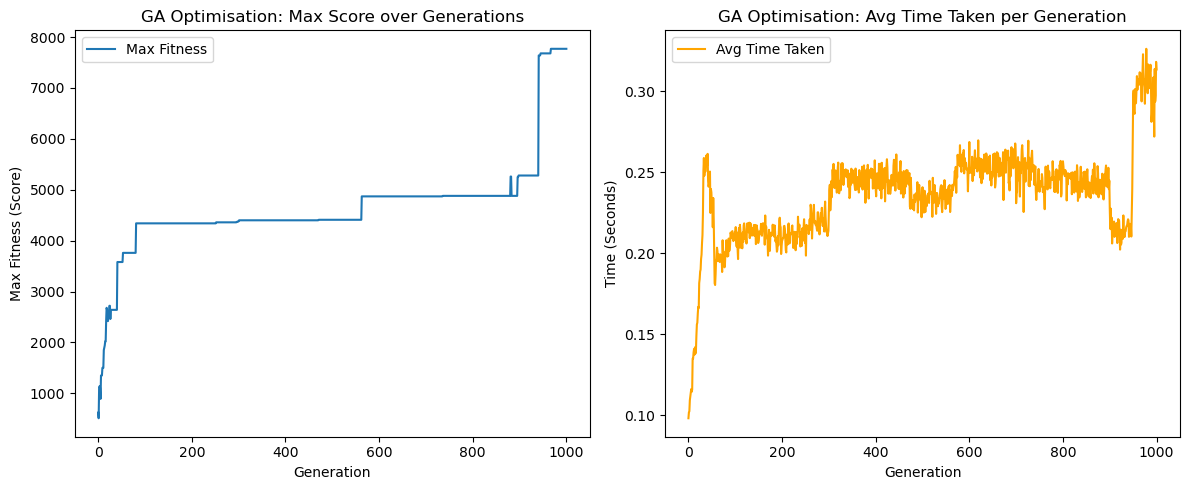

In [12]:
# Plot fitness progress over generations
plt.figure(figsize=(12, 5))

# Plot max fitness
plt.subplot(1, 2, 1)
plt.plot(gen, max_fitness, label="Max Fitness")
plt.xlabel("Generation")
plt.ylabel("Max Fitness (Score)")
plt.title("GA Optimisation: Max Score over Generations")
plt.legend()

# Plot time taken per generation
plt.subplot(1, 2, 2)
plt.plot(gen, avg_time, label="Avg Time Taken", color='orange')
plt.xlabel("Generation")
plt.ylabel("Time (Seconds)")
plt.title("GA Optimisation: Avg Time Taken per Generation")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Optimisation process notes

# The genetic algorithm evolves agents that maximise the score in Ms. Pac-Man. 
# As the generations progress, agents should improve their ability to score more points by learning better sequences of actions.
# The simulation can be run multiple times to observe how different configurations or hyperparameters (e.g., population size, crossover probability, mutation rate, and number of generations) affect performance of evolved agents

In [14]:
# Results analysis

# Analyse the evolved agents:
# Best agent behaviour: After the final generation, extract the best individual and test how well it performs in the game.

best_ind = tools.selBest(final_pop, k=1)[0]

def evaluate_agent_multiple_times(agent, n_episodes=5):
    rewards = []
    for seed in range(n_episodes):
        rewards.append(evaluate_agent(agent, seed=seed)[0])
    
    avg_reward = np.mean(rewards)
    print(f"Best Agent's Average Total Reward over {n_episodes} episodes: {avg_reward}")
    return avg_reward

# Evaluate the best agent over multiple episodes
avg_total_reward = evaluate_agent_multiple_times(best_ind, n_episodes=5)

# Evaluate the best agent over multiple episodes to get a consistent performance estimate
evaluate_agent_multiple_times(best_ind, n_episodes=5)

# Evaluate the best agent
total_reward = evaluate_agent(best_ind)[0]
print(f"Best Agent's Total Reward: {total_reward}")

Best Agent's Average Total Reward over 5 episodes: 256.0
Best Agent's Average Total Reward over 5 episodes: 256.0
Best Agent's Total Reward: 7770.0


## Video playback of best performing agent

Using ffmpeg and wrappers from Gymnasium to record video with statistics

In [19]:
# Set the correct path to ffmpeg
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

def play_best_agent_with_video(agent, video_dir="/Users/catherineiwata/Desktop/Final_Project/code/videos", render=False, delay=0.025):
    # Ensure the video directory exists
    os.makedirs(video_dir, exist_ok=True)

    # Create a temporary environment that uses rgb_array for video recording
    tmp_env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    
    # Wrap the environment in RecordVideo wrapper
    env = RecordVideo(env=tmp_env, video_folder=video_dir, name_prefix="best_agent", episode_trigger=lambda x: x == 0)
    
    env = RecordEpisodeStatistics(env)
    
    # Reset the environment for a fresh start
    observation, info = env.reset(seed=42)

    total_reward = 0
    terminated = False
    steps = 0
    
    start_time = time.time()  # Track the real start time for the episode

    # Play the game with the best agent's action sequence
    while not terminated:
        if render:
            env.render()  # Render for real-time visualisation
            time.sleep(delay)  # Delay for easier viewing (does not affect time_queue)

        # Use the limited action set for the agent
        action = agent[steps % len(agent)]
        action = limited_actions[action % len(limited_actions)]
        
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        
        specific_keys = ['lives', 'episode_frame_number', 'frame_number']
        for key in specific_keys:
            if key in info:
                print(f"{key}: {info[key]}")

        if terminated or truncated:
            observation, info = env.reset()

    # Calculate the real time taken based on the start time
    real_time_taken = time.time() - start_time

    # Close the environment (video will be saved automatically)
    env.close()

    print(f"Total Reward: {total_reward}")
    print(f"Video saved in {video_dir}")
    print(f"Real Episode time taken: {real_time_taken} seconds")  # Real time taken
    print(f'Episode time taken (env): {env.time_queue}')  # Actual time recorded by the environment
    print(f'Episode total rewards: {env.return_queue}')
    print(f'Episode lengths: {env.length_queue}')
    print("Info keys:", info.keys())
    
    specific_keys = ['lives', 'episode_frame_number', 'frame_number']
    for key in specific_keys:
        if key in info:
            print(f"{key}: {info[key]}")
    
# Where 'best_ind' is the best individual from the genetic algorithm
play_best_agent_with_video(best_ind, video_dir="/Users/catherineiwata/Desktop/Final_Project/code/videos", render=True, delay=0.025)


lives: 3
episode_frame_number: 4
frame_number: 4
lives: 3
episode_frame_number: 8
frame_number: 8
lives: 3
episode_frame_number: 12
frame_number: 12


/Users/catherineiwata/anaconda3/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/catherineiwata/Desktop/Final_Project/code/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


lives: 3
episode_frame_number: 16
frame_number: 16
lives: 3
episode_frame_number: 20
frame_number: 20
lives: 3
episode_frame_number: 24
frame_number: 24
lives: 3
episode_frame_number: 28
frame_number: 28
lives: 3
episode_frame_number: 32
frame_number: 32
lives: 3
episode_frame_number: 36
frame_number: 36
lives: 3
episode_frame_number: 40
frame_number: 40
lives: 3
episode_frame_number: 44
frame_number: 44
lives: 3
episode_frame_number: 48
frame_number: 48
lives: 3
episode_frame_number: 52
frame_number: 52
lives: 3
episode_frame_number: 56
frame_number: 56
lives: 3
episode_frame_number: 60
frame_number: 60
lives: 3
episode_frame_number: 64
frame_number: 64
lives: 3
episode_frame_number: 68
frame_number: 68
lives: 3
episode_frame_number: 72
frame_number: 72
lives: 3
episode_frame_number: 76
frame_number: 76
lives: 3
episode_frame_number: 80
frame_number: 80
lives: 3
episode_frame_number: 84
frame_number: 84
lives: 3
episode_frame_number: 88
frame_number: 88
lives: 3
episode_frame_number: 

lives: 3
episode_frame_number: 648
frame_number: 648
lives: 3
episode_frame_number: 652
frame_number: 652
lives: 3
episode_frame_number: 656
frame_number: 656
lives: 3
episode_frame_number: 660
frame_number: 660
lives: 3
episode_frame_number: 664
frame_number: 664
lives: 3
episode_frame_number: 668
frame_number: 668
lives: 3
episode_frame_number: 672
frame_number: 672
lives: 3
episode_frame_number: 676
frame_number: 676
lives: 3
episode_frame_number: 680
frame_number: 680
lives: 3
episode_frame_number: 684
frame_number: 684
lives: 3
episode_frame_number: 688
frame_number: 688
lives: 3
episode_frame_number: 692
frame_number: 692
lives: 3
episode_frame_number: 696
frame_number: 696
lives: 3
episode_frame_number: 700
frame_number: 700
lives: 3
episode_frame_number: 704
frame_number: 704
lives: 3
episode_frame_number: 708
frame_number: 708
lives: 3
episode_frame_number: 712
frame_number: 712
lives: 3
episode_frame_number: 716
frame_number: 716
lives: 3
episode_frame_number: 720
frame_numbe

lives: 3
episode_frame_number: 1264
frame_number: 1264
lives: 3
episode_frame_number: 1268
frame_number: 1268
lives: 3
episode_frame_number: 1272
frame_number: 1272
lives: 3
episode_frame_number: 1276
frame_number: 1276
lives: 3
episode_frame_number: 1280
frame_number: 1280
lives: 3
episode_frame_number: 1284
frame_number: 1284
lives: 3
episode_frame_number: 1288
frame_number: 1288
lives: 3
episode_frame_number: 1292
frame_number: 1292
lives: 3
episode_frame_number: 1296
frame_number: 1296
lives: 3
episode_frame_number: 1300
frame_number: 1300
lives: 3
episode_frame_number: 1304
frame_number: 1304
lives: 3
episode_frame_number: 1308
frame_number: 1308
lives: 3
episode_frame_number: 1312
frame_number: 1312
lives: 3
episode_frame_number: 1316
frame_number: 1316
lives: 3
episode_frame_number: 1320
frame_number: 1320
lives: 3
episode_frame_number: 1324
frame_number: 1324
lives: 3
episode_frame_number: 1328
frame_number: 1328
lives: 3
episode_frame_number: 1332
frame_number: 1332
lives: 3
e

lives: 3
episode_frame_number: 1864
frame_number: 1864
lives: 3
episode_frame_number: 1868
frame_number: 1868
lives: 3
episode_frame_number: 1872
frame_number: 1872
lives: 3
episode_frame_number: 1876
frame_number: 1876
lives: 3
episode_frame_number: 1880
frame_number: 1880
lives: 3
episode_frame_number: 1884
frame_number: 1884
lives: 3
episode_frame_number: 1888
frame_number: 1888
lives: 3
episode_frame_number: 1892
frame_number: 1892
lives: 3
episode_frame_number: 1896
frame_number: 1896
lives: 3
episode_frame_number: 1900
frame_number: 1900
lives: 3
episode_frame_number: 1904
frame_number: 1904
lives: 3
episode_frame_number: 1908
frame_number: 1908
lives: 3
episode_frame_number: 1912
frame_number: 1912
lives: 3
episode_frame_number: 1916
frame_number: 1916
lives: 3
episode_frame_number: 1920
frame_number: 1920
lives: 3
episode_frame_number: 1924
frame_number: 1924
lives: 3
episode_frame_number: 1928
frame_number: 1928
lives: 3
episode_frame_number: 1932
frame_number: 1932
lives: 3
e

lives: 3
episode_frame_number: 2468
frame_number: 2468
lives: 3
episode_frame_number: 2472
frame_number: 2472
lives: 3
episode_frame_number: 2476
frame_number: 2476
lives: 3
episode_frame_number: 2480
frame_number: 2480
lives: 3
episode_frame_number: 2484
frame_number: 2484
lives: 3
episode_frame_number: 2488
frame_number: 2488
lives: 3
episode_frame_number: 2492
frame_number: 2492
lives: 3
episode_frame_number: 2496
frame_number: 2496
lives: 3
episode_frame_number: 2500
frame_number: 2500
lives: 3
episode_frame_number: 2504
frame_number: 2504
lives: 3
episode_frame_number: 2508
frame_number: 2508
lives: 3
episode_frame_number: 2512
frame_number: 2512
lives: 3
episode_frame_number: 2516
frame_number: 2516
lives: 3
episode_frame_number: 2520
frame_number: 2520
lives: 3
episode_frame_number: 2524
frame_number: 2524
lives: 3
episode_frame_number: 2528
frame_number: 2528
lives: 3
episode_frame_number: 2532
frame_number: 2532
lives: 3
episode_frame_number: 2536
frame_number: 2536
lives: 3
e

lives: 3
episode_frame_number: 3068
frame_number: 3068
lives: 3
episode_frame_number: 3072
frame_number: 3072
lives: 3
episode_frame_number: 3076
frame_number: 3076
lives: 3
episode_frame_number: 3080
frame_number: 3080
lives: 3
episode_frame_number: 3084
frame_number: 3084
lives: 3
episode_frame_number: 3088
frame_number: 3088
lives: 3
episode_frame_number: 3092
frame_number: 3092
lives: 3
episode_frame_number: 3096
frame_number: 3096
lives: 3
episode_frame_number: 3100
frame_number: 3100
lives: 3
episode_frame_number: 3104
frame_number: 3104
lives: 3
episode_frame_number: 3108
frame_number: 3108
lives: 3
episode_frame_number: 3112
frame_number: 3112
lives: 3
episode_frame_number: 3116
frame_number: 3116
lives: 3
episode_frame_number: 3120
frame_number: 3120
lives: 3
episode_frame_number: 3124
frame_number: 3124
lives: 3
episode_frame_number: 3128
frame_number: 3128
lives: 3
episode_frame_number: 3132
frame_number: 3132
lives: 3
episode_frame_number: 3136
frame_number: 3136
lives: 3
e

lives: 3
episode_frame_number: 3672
frame_number: 3672
lives: 3
episode_frame_number: 3676
frame_number: 3676
lives: 3
episode_frame_number: 3680
frame_number: 3680
lives: 3
episode_frame_number: 3684
frame_number: 3684
lives: 3
episode_frame_number: 3688
frame_number: 3688
lives: 3
episode_frame_number: 3692
frame_number: 3692
lives: 3
episode_frame_number: 3696
frame_number: 3696
lives: 3
episode_frame_number: 3700
frame_number: 3700
lives: 3
episode_frame_number: 3704
frame_number: 3704
lives: 3
episode_frame_number: 3708
frame_number: 3708
lives: 3
episode_frame_number: 3712
frame_number: 3712
lives: 3
episode_frame_number: 3716
frame_number: 3716
lives: 3
episode_frame_number: 3720
frame_number: 3720
lives: 3
episode_frame_number: 3724
frame_number: 3724
lives: 3
episode_frame_number: 3728
frame_number: 3728
lives: 3
episode_frame_number: 3732
frame_number: 3732
lives: 3
episode_frame_number: 3736
frame_number: 3736
lives: 3
episode_frame_number: 3740
frame_number: 3740
lives: 3
e

lives: 3
episode_frame_number: 4276
frame_number: 4276
lives: 3
episode_frame_number: 4280
frame_number: 4280
lives: 3
episode_frame_number: 4284
frame_number: 4284
lives: 3
episode_frame_number: 4288
frame_number: 4288
lives: 3
episode_frame_number: 4292
frame_number: 4292
lives: 3
episode_frame_number: 4296
frame_number: 4296
lives: 3
episode_frame_number: 4300
frame_number: 4300
lives: 3
episode_frame_number: 4304
frame_number: 4304
lives: 3
episode_frame_number: 4308
frame_number: 4308
lives: 3
episode_frame_number: 4312
frame_number: 4312
lives: 3
episode_frame_number: 4316
frame_number: 4316
lives: 3
episode_frame_number: 4320
frame_number: 4320
lives: 3
episode_frame_number: 4324
frame_number: 4324
lives: 3
episode_frame_number: 4328
frame_number: 4328
lives: 3
episode_frame_number: 4332
frame_number: 4332
lives: 3
episode_frame_number: 4336
frame_number: 4336
lives: 3
episode_frame_number: 4340
frame_number: 4340
lives: 3
episode_frame_number: 4344
frame_number: 4344
lives: 3
e

lives: 2
episode_frame_number: 4872
frame_number: 4872
lives: 2
episode_frame_number: 4876
frame_number: 4876
lives: 2
episode_frame_number: 4880
frame_number: 4880
lives: 2
episode_frame_number: 4884
frame_number: 4884
lives: 2
episode_frame_number: 4888
frame_number: 4888
lives: 2
episode_frame_number: 4892
frame_number: 4892
lives: 2
episode_frame_number: 4896
frame_number: 4896
lives: 2
episode_frame_number: 4900
frame_number: 4900
lives: 2
episode_frame_number: 4904
frame_number: 4904
lives: 2
episode_frame_number: 4908
frame_number: 4908
lives: 2
episode_frame_number: 4912
frame_number: 4912
lives: 2
episode_frame_number: 4916
frame_number: 4916
lives: 2
episode_frame_number: 4920
frame_number: 4920
lives: 2
episode_frame_number: 4924
frame_number: 4924
lives: 2
episode_frame_number: 4928
frame_number: 4928
lives: 2
episode_frame_number: 4932
frame_number: 4932
lives: 2
episode_frame_number: 4936
frame_number: 4936
lives: 2
episode_frame_number: 4940
frame_number: 4940
lives: 2
e

lives: 1
episode_frame_number: 5476
frame_number: 5476
lives: 1
episode_frame_number: 5480
frame_number: 5480
lives: 1
episode_frame_number: 5484
frame_number: 5484
lives: 1
episode_frame_number: 5488
frame_number: 5488
lives: 1
episode_frame_number: 5492
frame_number: 5492
lives: 1
episode_frame_number: 5496
frame_number: 5496
lives: 1
episode_frame_number: 5500
frame_number: 5500
lives: 1
episode_frame_number: 5504
frame_number: 5504
lives: 1
episode_frame_number: 5508
frame_number: 5508
lives: 1
episode_frame_number: 5512
frame_number: 5512
lives: 1
episode_frame_number: 5516
frame_number: 5516
lives: 1
episode_frame_number: 5520
frame_number: 5520
lives: 1
episode_frame_number: 5524
frame_number: 5524
lives: 1
episode_frame_number: 5528
frame_number: 5528
lives: 1
episode_frame_number: 5532
frame_number: 5532
lives: 1
episode_frame_number: 5536
frame_number: 5536
lives: 1
episode_frame_number: 5540
frame_number: 5540
lives: 1
episode_frame_number: 5544
frame_number: 5544
lives: 1
e

lives: 1
episode_frame_number: 6076
frame_number: 6076
lives: 1
episode_frame_number: 6080
frame_number: 6080
lives: 1
episode_frame_number: 6084
frame_number: 6084
lives: 1
episode_frame_number: 6088
frame_number: 6088
lives: 1
episode_frame_number: 6092
frame_number: 6092
lives: 1
episode_frame_number: 6096
frame_number: 6096
lives: 1
episode_frame_number: 6100
frame_number: 6100
lives: 1
episode_frame_number: 6104
frame_number: 6104
lives: 1
episode_frame_number: 6108
frame_number: 6108
lives: 1
episode_frame_number: 6112
frame_number: 6112
lives: 1
episode_frame_number: 6116
frame_number: 6116
lives: 1
episode_frame_number: 6120
frame_number: 6120
lives: 1
episode_frame_number: 6124
frame_number: 6124
lives: 1
episode_frame_number: 6128
frame_number: 6128
lives: 1
episode_frame_number: 6132
frame_number: 6132
lives: 1
episode_frame_number: 6136
frame_number: 6136
lives: 1
episode_frame_number: 6140
frame_number: 6140
lives: 1
episode_frame_number: 6144
frame_number: 6144
lives: 1
e

lives: 1
episode_frame_number: 6684
frame_number: 6684
lives: 1
episode_frame_number: 6688
frame_number: 6688
lives: 1
episode_frame_number: 6692
frame_number: 6692
lives: 1
episode_frame_number: 6696
frame_number: 6696
lives: 1
episode_frame_number: 6700
frame_number: 6700
lives: 1
episode_frame_number: 6704
frame_number: 6704
lives: 1
episode_frame_number: 6708
frame_number: 6708
lives: 1
episode_frame_number: 6712
frame_number: 6712
lives: 1
episode_frame_number: 6716
frame_number: 6716
lives: 1
episode_frame_number: 6720
frame_number: 6720
lives: 1
episode_frame_number: 6724
frame_number: 6724
lives: 1
episode_frame_number: 6728
frame_number: 6728
lives: 1
episode_frame_number: 6732
frame_number: 6732
lives: 1
episode_frame_number: 6736
frame_number: 6736
lives: 1
episode_frame_number: 6740
frame_number: 6740
lives: 1
episode_frame_number: 6744
frame_number: 6744
lives: 1
episode_frame_number: 6748
frame_number: 6748
lives: 1
episode_frame_number: 6752
frame_number: 6752
lives: 1
e